# Multi-Task Learning using Siamese Network


A Siamese Network or Twin Network is a neural network architecture that contains two or more identical subnetworks used to generate feature vectors (embeddings) for multiple input samples and compare them. Specifically, the subnetworks learn embeddings of their respective inputs via weight sharing.

In this notebook, we use the Siamese Network architecture for implementing the Multi-Task Learning (MTL) approach to solve a classification problem using TensorFlow Keras. In MTL, we solve the original task (e.g., classification) by learning shared representations while solving a related or auxilary task (another classification problem).

The Siamese Network is used to align the embeddings in the shared layers. It does so by maxmizing the distance (contrast) between embeddings of inputs of different classes, while minimizing the distance between embeddings of similar classes. As a result, the shared embedding space should reflect the class segmentation of the training inputs.


The Siamese Network architecture used in this notebook consists of two identical Multi-Layer Perceptron (MLP) subnetworks (that contains the shared layers). Inputs of the original task and the auxilary task are passed through this shared network. These two tasks are desinged as classification tasks. At the end of the shared network, a pair of task specific layers (classification layers) is appended for these two tasks.
- Original Task: predict the original label
- Auxilary task: predict the rotation (angle) of the original image. A new dataset is created that contains rotated versions (by 90 degree or 180 degree) of the original images. Depending on the rotation angle, a new label is attached with each rotated image (label 1 for rotation degree 90, and 2 for rotation degree 180).

The Siamese Network is trained to solve these two classification problems using the cross-entropy loss function. At the same time, it tries to minimize the Euclidean distance between the embeddings (at the final layer of the shared network) of the pairs of images. For distance minimization, the contrastive loss function is used.


## Experiments

Using the Siamese Network, we perform two experiments on the MTL approach.
- Experiment 1: the Siamese Network Minimizes the Distance of the Pairs of Embeddings via Contrastive Learning
- Experiment 2: the Siamese Network Does not Minimize the Distance of the Pairs of Embeddings


## Dataset
We use the MNIST handwritten digits dataset.


## Observation
We will see that experiment 2 obtains better classification performance, i.e., by using the Siamese Network architecture that does not minimize the distance of the pairs of embeddings. Thus, it seems that for the MNIST handwritten digits dataset, minimizing the distance of the embeddings is not useful. Learning a shared embedding space appears to be more effective.

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import tensorflow as tf
import tensorflow_addons as tfa

## Load the Dataset

We load the train and test dataset using Keras datasets API. Then, scale it.

In [2]:
# Load the MNIST dataset (train and test subsets)
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Cast the datatype ofthe features
X_train_full = X_train_full.astype('float32')
X_test = X_test.astype('float32')


# Create validation dataset as well as scale the data
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.0


print("No. of Training Samples: ", X_train.shape)
print("No. of Training Labels: ", y_train.shape)

print("\nNo. of Validation Samples: ", X_valid.shape)
print("No. of Validation Labels: ", y_valid.shape)

print("\nNo. of Testing Samples: ", X_test.shape)
print("No. of Testing Labels: ", y_test.shape)

print("\nX type: ", X_train.dtype)
print("y type: ", y_train.dtype)

# Get the shape of the samples
input_shape = X_train.shape[1:]
print("\nInput Shape: ", input_shape)

No. of Training Samples:  (55000, 28, 28)
No. of Training Labels:  (55000,)

No. of Validation Samples:  (5000, 28, 28)
No. of Validation Labels:  (5000,)

No. of Testing Samples:  (10000, 28, 28)
No. of Testing Labels:  (10000,)

X type:  float32
y type:  uint8

Input Shape:  (28, 28)


## Functions for Rotating Images

In [3]:
'''
This function rotates an image randomly by 
either degree "rotation_angle_degree" or "rotation_angle_degree"+90
It returns the rotated image and its "label"
    label = 0: rotation degree = "rotation_angle_degree"
    label = 1: rotation degree = "rotation_angle_degree" + 90
'''
def rotate_randomly(x, rotation_angle_degree):
    
    rand_val = np.random.random_sample()
    label = -1
    if(rand_val < 0.5):
        rotation_angle_radian = rotation_angle_degree * (3.1416/ 180)
        x = tfa.image.rotate(x, rotation_angle_radian, fill_mode='nearest', interpolation='bilinear')
        label = 0
    else:
        rotation_angle_radian = (rotation_angle_degree + 90) * (3.1416/ 180)
        x = tfa.image.rotate(x, rotation_angle_radian, fill_mode='nearest', interpolation='bilinear')
        label = 1
    return x, label



'''
This function takes a data marix X and returns another matrix X_rot of the same shape
X_rot contains rotated versions (by 90 degree or 180 degree) of the images in X
It also returns a label matrix, which assigns 0/1 to each rotated image in X_rot as follows.
    label = 0; if rotation = 90 degree
    label = 1; if rotation = 180 degree
'''
def create_rotated_images_labels(X):
    
    '''
    Create a data matrix to store rotated version of the samples in X 
    '''
    X_rot = X.copy()
    
    '''
    Create a binary label matrix to store the labels of the rotated samples
    in X_rot
    '''
    y_rot = np.zeros((X_rot.shape[0], 2))
    
    
    for i in range(X.shape[0]):
        '''
        Rotate an image randomly by either degree 90 or 180
        label = 0; if rotation = 90 degree
        label = 1; if rotation = 180 degree
        '''
        rotated_image, label = rotate_randomly(X[i], 90)

        # Store the rotated image in X_rot
        X_rot[i] = rotated_image

        # Store the label for the rotated image in y_rot
        if(label == 0):
            y_rot[i][0] = 1
        else:
            y_rot[i][1] = 1
            
    return X_rot, y_rot

## Create a Dataset Containing Rotated Versions of the Original Images

In [4]:
%%time
'''
Create data & label matrices of rotated images for train, test, and validation samples
'''
X_train_rot, y_train_rot = create_rotated_images_labels(X_train)
X_test_rot, y_test_rot = create_rotated_images_labels(X_test)
X_valid_rot, y_valid_rot = create_rotated_images_labels(X_valid)

CPU times: user 3min 49s, sys: 334 ms, total: 3min 50s
Wall time: 3min 50s


## Visualize an Original Image and Its Rotated Version

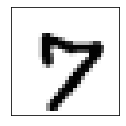

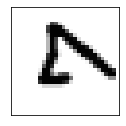

In [5]:
index = 49

plt.figure(figsize=(2,2))
plt.imshow(X_train[index], interpolation="nearest", cmap="Greys")
plt.xticks(())
plt.yticks(())
plt.show()

plt.figure(figsize=(2,2))
plt.imshow(X_train_rot[index], interpolation="nearest", cmap="Greys")
plt.xticks(())
plt.yticks(())
plt.show()

## Create Pair of Samples with Similar and Dissimilar Images

So far, we created two types of data matrices: original samples & rotated samples. For each original sample in the data matrix, we have its rotated version in the rotated data matrix, at the same index.

Now, we will randomize half of the rotated data matrix such that 
- 50% of the original images will have their rotated versions at the same index
- 50% of the original images will have rotated versions of different images at the same index

This will allow us to compare the distance of the representations of the pairs of samples between the original and rotated data matrices. Specifically, in 50% pairs each image will have its rotated version (thus their representations should be the same) while in 50% pairs each image will have another image's rotated version (thus their representations should be different).

After shuffling half of the rotated data matrix (last 50%), we define a label list to store the true distances between the pairs.
- If a sample has its rotated version at the same index, then label = 1, otherwise 0

In [6]:
'''
This function creates pairs of similar and dissimilar images & assigns new labels
'''   
def create_similar_dissimilar_pairs(X_rot, y_rot):
    '''
    Shuffling will done on the last 50% samples
    Get the begin and end index for sample shuffling
    '''
    index_begin = X_rot.shape[0] // 2
    index_end = X_rot.shape[0] 

    #print(index_begin)
    #print(index_end)

    '''
    Get a set of indices (from the last 50% samples) 
    that will be used to shuffle the corresponding samples
    '''
    indices = np.arange(index_begin, index_end)

    '''
    Shuffle the idices of last 50% samples
    '''
    np.random.shuffle(indices)


    '''
    Create a data and label matrix to store both the unshuffled
    and shuffled samples
    '''
    X_rot_suffled = X_rot.copy()
    y_rot_suffled = y_rot.copy()

    '''
    Create a label list as follows.
    - Label = 1: sample is unshuffled
    - Label = 0: sample is shuffled
    '''
    y_distance = np.ones(X_rot.shape[0])


    '''
    Using the shuffled indices for the last 50% samples,
    create a new data and label matrix that store both unshuffled 
    and shuffled samples and their labels
    Also update the label list to set whether a sample is shuffled or unshuffled
    '''
    for i in range(X_rot.shape[0]):
        if(i < index_begin):
            X_rot_suffled[i] = X_rot[i]
            y_rot_suffled[i] = y_rot[i]

        else:
            X_rot_suffled[i] = X_rot[indices[i-index_begin]]
            y_rot_suffled[i] = y_rot[indices[i-index_begin]]
            y_distance[i] = 0
            
    return X_rot_suffled, y_rot_suffled, y_distance 



## Create Data and Label Matrices for Storing the Rotated Images (last 50% images are shuffled)

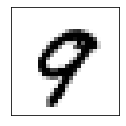

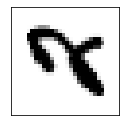

In [7]:
'''
Create data and label matrices for storing the rotated images (last 50% images are shuffled)
'''
X_train_rot_shuffled, y_train_rot_shuffled, y_train_distance = create_similar_dissimilar_pairs(X_train_rot, y_train_rot)
X_test_rot_shuffled, y_test_rot_shuffled, y_test_distance = create_similar_dissimilar_pairs(X_test_rot, y_test_rot)
X_valid_rot_shuffled, y_valid_rot_shuffled, y_valid_distance = create_similar_dissimilar_pairs(X_valid_rot, y_valid_rot)


'''
Visualize an original image and its rotated version
For the first half of the dataset, an image will have its rotated version at the same index.
'''

index = 4989
image_original = X_valid[index]
image_rotated = X_valid_rot_shuffled[index]

plt.figure(figsize=(2,2))
plt.imshow(image_original, interpolation="nearest", cmap="Greys")
plt.xticks(())
plt.yticks(())
plt.show()

plt.figure(figsize=(2,2))
plt.imshow(image_rotated, interpolation="nearest", cmap="Greys")
plt.xticks(())
plt.yticks(())
plt.show()

## Create Categorical Labels for the Original Task

In [8]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
y_valid = tf.keras.utils.to_categorical(y_valid)

print("Shape of the training labels: ", y_train.shape)

Shape of the training labels:  (55000, 10)


## Functions for the MTL Approach

In [9]:
'''
This function creates a base MLP network (shared layers) for learning shared representations
'''
def create_base_network(input_shape):
    input_ = tf.keras.Input(shape=input_shape)
    
    # Since the network is MLP, we need to flatten the input data
    input_flatten = tf.keras.layers.Flatten()(input_)
    hidden1 = tf.keras.layers.Dense(300, activation="relu")(input_flatten)
    hidden2 = tf.keras.layers.Dense(100, activation="relu")(hidden1)
    hidden2 = tf.keras.layers.Dropout(0.4)(hidden2)
    return tf.keras.models.Model(input_, hidden2)


'''
This function creates a base CNN (shallow) network (shared layers) for learning shared representations
'''
def create_base_network_cnn_shallow(input_shape):
    
    input_shape = (28, 28, 1)
    
    initializer = 'he_normal'
    activation_func = 'relu'
    
    input_ = tf.keras.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(16, (3, 3), kernel_initializer=initializer, padding='same', use_bias=False)(input_)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer=initializer, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    
    return tf.keras.models.Model(input_, x)



'''
This function creates a base CNN (deep) network (shared layers) for learning shared representations
'''
def create_base_network_cnn_deep(input_shape):
    
    input_ = tf.keras.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer=initializer, padding='same', use_bias=False)(input_)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.Conv2D(64, (3, 3), kernel_initializer=initializer, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    
    x = tf.keras.layers.Conv2D(64, (3, 3), kernel_initializer=initializer, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    return tf.keras.models.Model(input_, x)



'''
Compute the distance between two representations (feature vectors)
'''
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

'''
Define a contrastive loss function using the following equation.
Contrastive loss = mean((1-true_value) * square(prediction) + true_value * square( max(margin-prediction, 0) ))
'''
def contrastive_loss(y_true, y_pred):            
    margin = 1
    square_pred = tf.math.square(y_pred)
    margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
    return tf.math.reduce_mean(
        (1 - y_true) * square_pred + (y_true) * margin_square
    )

## Experiment 1: the Siamese Network Minimizes the Distance of the Pairs of Embeddings via Contrastive Learning

First, we create the Siamese Network.

Model: "Experiment-1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 100)          265600      input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[0][0]           

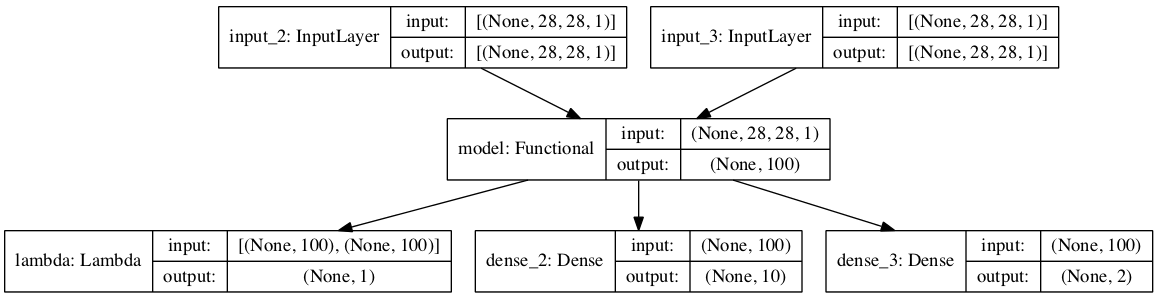

In [10]:
'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
tf.keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)

input_shape = (28, 28, 1)

'''
Create the base network for learning shared representations
'''
base_network = create_base_network(input_shape)


'''
Define the shape of the input for both tasks
'''
input_a = tf.keras.Input(shape=input_shape)
input_b = tf.keras.Input(shape=input_shape)

'''
Pass both inputs through the base network
It will create shared reprsentations
'''
processed_a = base_network(input_a)
processed_b = base_network(input_b)


distance = tf.keras.layers.Lambda(euclidean_distance, output_shape=None)([processed_a, processed_b])

'''
Create two task-specific layers
'''
output1 = tf.keras.layers.Dense(10, activation="softmax")(processed_a)
output2 = tf.keras.layers.Dense(2, activation="sigmoid")(processed_b)


'''
Create a Model by specifying its input and outputs
'''
model = tf.keras.models.Model(inputs=[input_a, input_b], outputs=[distance, output1, output2], name="Experiment-1")


'''
Display the model summary
'''
model.summary()

'''
Display the model graph
'''
tf.keras.utils.plot_model(model, show_shapes=True)

## Experiment 1: Compile & Train the Siamese Network Model

In [11]:
%%time

'''
Define the optimizer
'''
optimizer=tf.keras.optimizers.SGD(learning_rate=1e-1, momentum=0.1)
#optimizer="adam"


'''
Compile the model.
Since labels for both tasks are categorical, we use the same loss function.
Otherwise we have to use specify the loss functions using a list.

Choice of loss function:
- contrastive_loss (we defined it earlier)
- categorical_crossentropy
'''
model.compile(loss=[contrastive_loss, "categorical_crossentropy", "binary_crossentropy"],
              optimizer=optimizer,
              metrics=["accuracy"])


'''
Create a callback object of early stopping
'''
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_dense_2_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)

'''
Train the model.
We need to specify two types of labels for training and validation using lists.
'''
history = model.fit([X_train, X_train_rot_shuffled], [y_train_distance, y_train, y_train_rot_shuffled], 
                    batch_size=64, 
                    epochs=30,
                    verbose=1,
                    validation_data=([X_valid, X_valid_rot_shuffled], [y_valid_distance, y_valid, y_valid_rot_shuffled]),
                    callbacks=[early_stopping_cb]
                    )

Epoch 1/30
860/860 [==============================] - 4s 3ms/step - loss: 2.6533 - lambda_loss: 0.4415 - dense_2_loss: 1.7004 - dense_3_loss: 0.5113 - lambda_accuracy: 0.5001 - dense_2_accuracy: 0.6630 - dense_3_accuracy: 0.8850 - val_loss: 1.6083 - val_lambda_loss: 0.3789 - val_dense_2_loss: 0.9357 - val_dense_3_loss: 0.2937 - val_lambda_accuracy: 0.4922 - val_dense_2_accuracy: 0.8990 - val_dense_3_accuracy: 0.9744
Epoch 2/30
860/860 [==============================] - 3s 3ms/step - loss: 1.5691 - lambda_loss: 0.5505 - dense_2_loss: 0.7881 - dense_3_loss: 0.2305 - lambda_accuracy: 0.4995 - dense_2_accuracy: 0.9096 - dense_3_accuracy: 0.9811 - val_loss: 1.0619 - val_lambda_loss: 0.3142 - val_dense_2_loss: 0.5454 - val_dense_3_loss: 0.2023 - val_lambda_accuracy: 0.4874 - val_dense_2_accuracy: 0.9442 - val_dense_3_accuracy: 0.9588
Epoch 3/30
860/860 [==============================] - 3s 3ms/step - loss: 1.1880 - lambda_loss: 0.4980 - dense_2_loss: 0.5342 - dense_3_loss: 0.1558 - lambda_ac

## Experiment 1: Evaluate the Siamese Network Model

In [12]:
numOfEpochs = len(history.history['loss'])
print("Epochs: ", numOfEpochs)

print("\n******************** Multiclass Classification ********************************************")


'''
Prediction for test data
'''
# model.predict() method returns C probabilities per class for each instance (Dimension NxC), where C = #classes
y_test_predicted = model.predict([X_test, X_test_rot_shuffled])
y_test_predicted_multiclass = np.argmax(y_test_predicted[1], axis=1) # get the label/index of the highest probability class
y_test_predicted_binary = np.argmax(y_test_predicted[2], axis=1) # get the label/index of the highest probability class


'''
Prediction for training data
'''
y_train_predicted = model.predict([X_train, X_train_rot_shuffled])
y_train_predicted_multiclass = np.argmax(y_train_predicted[1], axis=1) # get the label/index of the highest probability class
y_train_predicted_binary = np.argmax(y_train_predicted[2], axis=1) # get the label/index of the highest probability class



'''
Get the integer labels for the multiclass data
'''
y_test_multiclass = np.argmax(y_test, axis=1) # get the label/index of the highest probability class
y_train_multiclass = np.argmax(y_train, axis=1) # get the label/index of the highest probability class


'''
Compute the train & test accuracies for the multiclass data
'''
train_accuracy_multiclass = accuracy_score(y_train_predicted_multiclass, y_train_multiclass)
test_accuracy_multiclass = accuracy_score(y_test_predicted_multiclass, y_test_multiclass)


print("\nMulticlass Classification - Train Accuracy: ", train_accuracy_multiclass)
print("Multiclass Classification - Test Accuracy: ", test_accuracy_multiclass)


print("\nTest Confusion Matrix (Multiclass):")
print(confusion_matrix(y_test_multiclass, y_test_predicted_multiclass))

print("\nClassification Report (Multiclass):")
print(classification_report(y_test_multiclass, y_test_predicted_multiclass))



print("\n******************** Binary Classification ********************************************")


'''
Get the integer labels for the binary data
'''
y_train_rot_binary = np.argmax(y_train_rot_shuffled, axis=1) # get the label/index of the highest probability class
y_test_rot_binary = np.argmax(y_test_rot_shuffled, axis=1) # get the label/index of the highest probability class


train_accuracy_binary = accuracy_score(y_train_rot_binary, y_train_predicted_binary)
test_accuracy_binary = accuracy_score(y_test_rot_binary, y_test_predicted_binary)

print("\nBinary Classification - Train Accuracy: ", train_accuracy_binary)
print("Binary Classification - Test Accuracy: ", test_accuracy_binary)


print("\nTest Confusion Matrix (Binary):")
print(confusion_matrix(y_test_rot_binary, y_test_predicted_binary))

print("\nClassification Report (Binary):")
print(classification_report(y_test_rot_binary, y_test_predicted_binary))

Epochs:  30

******************** Multiclass Classification ********************************************

Multiclass Classification - Train Accuracy:  0.993890909090909
Multiclass Classification - Test Accuracy:  0.9709

Test Confusion Matrix (Multiclass):
[[ 964    1    0    1    1    1    3    3    4    2]
 [   0 1122    3    2    1    2    2    0    3    0]
 [   4    2 1002    6    1    0    2    7    7    1]
 [   1    1    9  973    0    3    1    3   12    7]
 [   0    2    5    1  951    0    3    2    0   18]
 [   3    0    2   11    0  850   13    1    7    5]
 [   5    4    0    1    4    6  933    1    3    1]
 [   1    7    8    2    0    0    0  999    5    6]
 [   3    0    6    3    6    1    8    7  931    9]
 [   4    2    0    2    7    1    0    5    4  984]]

Classification Report (Multiclass):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.98      0.99      0.99      1135
           2

## Experiment 2: the Siamese Network Does not Minimize the Distance of the Pairs of Embeddings

Model: "Experiment-2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 100)          265600      input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 10)           1010        model[0][0]           

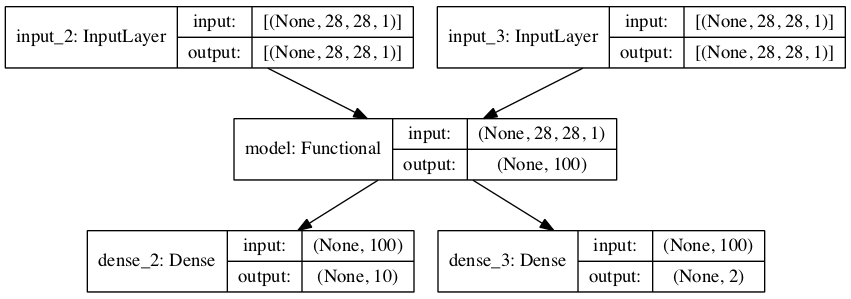

In [13]:
'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
tf.keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)

input_shape = (28, 28, 1)

'''
Create the base network for learning shared representations
'''
base_network = create_base_network(input_shape)


'''
Define the shape of the input for both tasks
'''
input_a = tf.keras.Input(shape=input_shape)
input_b = tf.keras.Input(shape=input_shape)

'''
Pass both inputs through the base network
It will create shared reprsentations
'''
processed_a = base_network(input_a)
processed_b = base_network(input_b)



'''
Create two task-specific layers
'''
output1 = tf.keras.layers.Dense(10, activation="softmax")(processed_a)
output2 = tf.keras.layers.Dense(2, activation="sigmoid")(processed_b)


'''
Create a Model by specifying its input and outputs
'''

model = tf.keras.models.Model(inputs=[input_a, input_b], outputs=[output1, output2], name="Experiment-2")

'''
Display the model summary
'''
model.summary()

'''
Display the model graph
'''
tf.keras.utils.plot_model(model, show_shapes=True)

## Experiment 2: Compile & Train the Siamese Network Model

In [14]:
%%time

'''
Define the optimizer
'''
optimizer=tf.keras.optimizers.SGD(learning_rate=1e-1, momentum=0.1)
#optimizer="adam"


'''
Compile the model.
Since labels for both tasks are categorical, we use the same loss function.
Otherwise we have to use specify the loss functions using a list.
'''

model.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])



'''
Create a callback object of early stopping
'''
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_dense_2_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)

'''
Train the model.
We need to specify two types of labels for training and validation using lists.
'''
history = model.fit([X_train, X_train_rot_shuffled], [y_train, y_train_rot_shuffled], 
                    batch_size=64, 
                    epochs=30,
                    verbose=1,
                    validation_data=([X_valid, X_valid_rot_shuffled], [y_valid, y_valid_rot_shuffled]),
                    callbacks=[early_stopping_cb]
                    )

Epoch 1/30
860/860 [==============================] - 3s 3ms/step - loss: 0.5127 - dense_2_loss: 0.4247 - dense_3_loss: 0.0880 - dense_2_accuracy: 0.8735 - dense_3_accuracy: 0.9692 - val_loss: 0.1954 - val_dense_2_loss: 0.1686 - val_dense_3_loss: 0.0268 - val_dense_2_accuracy: 0.9518 - val_dense_3_accuracy: 0.9902
Epoch 2/30
860/860 [==============================] - 3s 3ms/step - loss: 0.2247 - dense_2_loss: 0.1969 - dense_3_loss: 0.0278 - dense_2_accuracy: 0.9425 - dense_3_accuracy: 0.9906 - val_loss: 0.1667 - val_dense_2_loss: 0.1448 - val_dense_3_loss: 0.0219 - val_dense_2_accuracy: 0.9560 - val_dense_3_accuracy: 0.9928
Epoch 3/30
860/860 [==============================] - 2s 3ms/step - loss: 0.1658 - dense_2_loss: 0.1465 - dense_3_loss: 0.0193 - dense_2_accuracy: 0.9576 - dense_3_accuracy: 0.9937 - val_loss: 0.1054 - val_dense_2_loss: 0.0942 - val_dense_3_loss: 0.0112 - val_dense_2_accuracy: 0.9720 - val_dense_3_accuracy: 0.9962
Epoch 4/30
860/860 [==============================] 

## Experiment 2: Evaluate the Siamese Network Model

In [15]:
numOfEpochs = len(history.history['loss'])
print("Epochs: ", numOfEpochs)

print("\n******************** Multiclass Classification ********************************************")


'''
Prediction for test data
'''

# model.predict() method returns C probabilities per class for each instance (Dimension NxC), where C = #classes
y_test_predicted = model.predict([X_test, X_test_rot_shuffled])
y_test_predicted_multiclass = np.argmax(y_test_predicted[0], axis=1) # get the label/index of the highest probability class
y_test_predicted_binary = np.argmax(y_test_predicted[1], axis=1) # get the label/index of the highest probability class


'''
Prediction for training data
'''
y_train_predicted = model.predict([X_train, X_train_rot_shuffled])
y_train_predicted_multiclass = np.argmax(y_train_predicted[0], axis=1) # get the label/index of the highest probability class
y_train_predicted_binary = np.argmax(y_train_predicted[1], axis=1) # get the label/index of the highest probability class



'''
Get the integer labels for the multiclass data
'''
y_test_multiclass = np.argmax(y_test, axis=1) # get the label/index of the highest probability class
y_train_multiclass = np.argmax(y_train, axis=1) # get the label/index of the highest probability class


'''
Compute the train & test accuracies for the multiclass data
'''
train_accuracy_multiclass = accuracy_score(y_train_predicted_multiclass, y_train_multiclass)
test_accuracy_multiclass = accuracy_score(y_test_predicted_multiclass, y_test_multiclass)


print("\nMulticlass Classification - Train Accuracy: ", train_accuracy_multiclass)
print("Multiclass Classification - Test Accuracy: ", test_accuracy_multiclass)


print("\nTest Confusion Matrix (Multiclass):")
print(confusion_matrix(y_test_multiclass, y_test_predicted_multiclass))

print("\nClassification Report (Multiclass):")
print(classification_report(y_test_multiclass, y_test_predicted_multiclass))



print("\n******************** Binary Classification ********************************************")


'''
Get the integer labels for the binary data
'''
y_train_rot_binary = np.argmax(y_train_rot_shuffled, axis=1) # get the label/index of the highest probability class
y_test_rot_binary = np.argmax(y_test_rot_shuffled, axis=1) # get the label/index of the highest probability class


train_accuracy_binary = accuracy_score(y_train_rot_binary, y_train_predicted_binary)
test_accuracy_binary = accuracy_score(y_test_rot_binary, y_test_predicted_binary)

print("\nBinary Classification - Train Accuracy: ", train_accuracy_binary)
print("Binary Classification - Test Accuracy: ", test_accuracy_binary)


print("\nTest Confusion Matrix (Binary):")
print(confusion_matrix(y_test_rot_binary, y_test_predicted_binary))

print("\nClassification Report (Binary):")
print(classification_report(y_test_rot_binary, y_test_predicted_binary))

Epochs:  23

******************** Multiclass Classification ********************************************

Multiclass Classification - Train Accuracy:  0.9965636363636363
Multiclass Classification - Test Accuracy:  0.982

Test Confusion Matrix (Multiclass):
[[ 973    1    0    1    0    0    2    1    2    0]
 [   0 1128    3    1    0    1    1    1    0    0]
 [   1    1 1017    3    1    0    2    7    0    0]
 [   0    0    3  996    0    3    0    4    3    1]
 [   0    0    3    0  966    0    3    1    0    9]
 [   3    0    1    8    3  870    2    0    3    2]
 [   3    2    1    1    6    4  939    0    2    0]
 [   1    5    5    3    0    0    0 1010    2    2]
 [   4    1    5    7    2    3    3    4  943    2]
 [   1    5    1    7    8    0    1    8    0  978]]

Classification Report (Multiclass):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2

## Observation

We achieved better classification performance in experiment 2, i.e., by using the Siamese Network architecture that does not minimize the distance of the pairs of embeddings. Thus, it seems that for the MNIST handwritten digits dataset, minimizing the distance of the embeddings is not useful. Learning a shared embedding space appears to be more effective.